# Data exploration, analysis and module testing to build a stock monitoring dashboard.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("white")

import requests
import json
import csv
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

In [2]:
#%ls

## Get candlestick data from the API (Finnhub.io)

In [3]:
def get_candle_data(symbol, res, year_start, month_start, day_start, 
                    year_end, month_end, day_end):
    
    """Symbol is the stock's symbol and should be a string (e.g. "AAPL"). \n
       res is the resolution and should either be a number (1, 5, 15, 30, 60) 
       or a string ("D", "W", "M")"""
    
    # Converting standard time to UNIX time
    start_time = int(datetime(year_start, month_start, day_start).timestamp())
    end_time = int(datetime(year_end, month_end, day_end).timestamp())


    # URL format:
    url = 'https://finnhub.io/api/v1/stock/candle'
    params = {'symbol': symbol, 
          'resolution': res,  # 1 minute, Choices are 1, 5, 15, 30, 60, D, W, M 
          'from': str(start_time),
          'to': str(end_time),
          'token': token
         }

    # Fetching data
    r = requests.get(url, params)
    data = r.json()
    
    with open('data.json', 'w') as jsonfile:
        json.dump(data, jsonfile) 
    
    with open('data.json') as json_file: 
        data_extract = json.load(json_file) 
    
    print(data_extract['s'])   
    
    return data_extract

The returned .json contains different lists:
- o: list of open prices for returned candles.
- h: list of high prices for returned candles.
- l: list of low prices for returned candles.
- c: list of close prices for returned candles.
- v: list of volume data for returned candles.
- t: list of timestamp for returned candles.

To calculate the stock return, we are interested in prices (e.g. close, c), as well as time.

## Stocks visualization

Let's make a call to the API for the Apple stock (AAPL)

In [4]:
# API call
AAPL = get_candle_data('AAPL', 'M', 2010, 8, 18, 2020, 8, 18)

ok


In [5]:
def time_std_unix(time_unix):
    """Converts UNIX timestamps to standard time. Takes a timestamp list as an input."""
    
    time_std = []
    for time in time_unix:
        #ts = int(time)
        time_std.append(datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))
        
    return time_std

In [6]:
# Can only be called once or else it returns an error (once time is converted)
AAPL['t'] = time_std_unix(AAPL['t'])

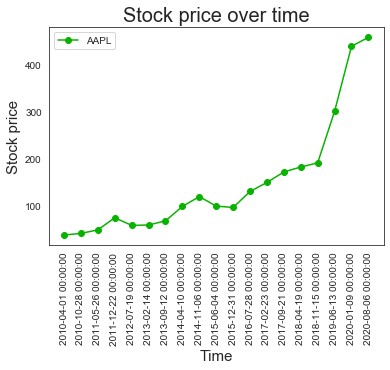

In [7]:
# Plot the price data over time
fig, ax = plt.subplots()
ax.plot(AAPL['t'], AAPL['c'], marker='o', c='#08B300', label='AAPL')
plt.xticks(rotation=90)
plt.xlabel('Time', size=15)
plt.ylabel('Stock price', size=15)
plt.title('Stock price over time', size=20)
plt.legend()
plt.show()

Let's now compare two stocks over the same period of time (Apple, AAPL; HD, Home Depot)

In [8]:
# API call for Home Depot (HD)
HD = get_candle_data('HD', 'M', 2010, 8, 18, 2020, 8, 18)

ok


In [9]:
HD['t'] = time_std_unix(HD['t'])

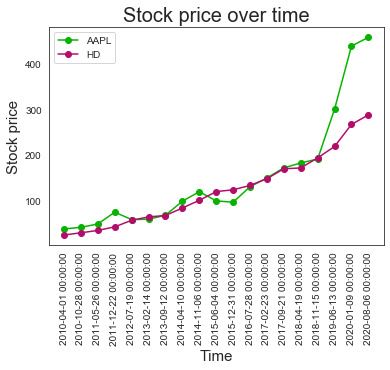

In [10]:
# Plot the price data over time
fig, ax = plt.subplots()
ax.plot(AAPL['t'], AAPL['c'], marker='o', c='#08B300', label='AAPL')
ax.plot(HD['t'], HD['c'], marker='o', c='#B30D6B', label='HD')
plt.xticks(rotation=90)
plt.xlabel('Time', size=15)
plt.ylabel('Stock price', size=15)
plt.title('Stock price over time', size=20)
plt.legend()
#plt.tight_layout()
plt.show()

## Calculating stock returns

In [11]:
def stock_return(price):
    """Calculates the return for each stock over each tick (in %)"""
    stock_return = []

    for i in range(1, len(price)):
        returns = ((price[i]/price[i-1])-1)*100
        stock_return.append(returns)
    
    return stock_return

In [12]:
# Calculate the returns for each stock
AAPL_return = stock_return(AAPL['c'])
HD_return = stock_return(HD['c'])

We also want to calculate the alpha and beta of these two stocks:

In [13]:
def linear_regression(returns_A, returns_B):
    """Calculates the covariance between two stocks"""
    # Input (x) and output (y) are arrays:
    x = np.array(returns_A).reshape((-1, 1))
    y = np.array(returns_B)

    # Create the model
    model = LinearRegression()
    
    # Fit with input and output data
    model.fit(x, y)
    print('R-squared:', model.score(x, y))
    print('alpha:', model.intercept_)
    print('beta:', model.coef_[0])

    return model.fit(x, y)

In [14]:
# Calculate linear regression for HD and AAPL
reg = linear_regression(HD_return, AAPL_return)

R-squared: 0.004516850641520742
alpha: 14.190610359967836
beta: 0.18108836642993856


In [15]:
# Get model parameters
alpha = reg.intercept_
beta = reg.coef_[0]

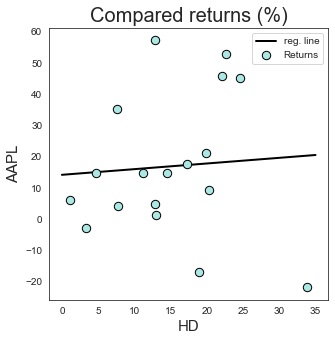

In [16]:
## Plot the returns
fig, ax = plt.subplots(figsize=(5,5))

# Plot data
ax.scatter(HD_return, AAPL_return, marker='o', c='#ACE8E3', edgecolor='k', s=70, label='Returns')

# Plot regression line
z = np.linspace(0., 35., 34)
w = z * beta + alpha
ax.plot(z, w, c='k', ls='solid', lw=2, zorder=-1, label="reg. line")

plt.xlabel('HD', size=15)
plt.ylabel('AAPL', size=15)
plt.title('Compared returns (%)', size=20)
plt.legend()
plt.show()

### 1. Calculating the covariance between two stocks

Calculating the covariance using np.cov( )

In [17]:
def covariance_two_stocks(return_A, return_B):
    """Prints out the covariance between two stocks. \n
    Takes in the calculated returns for both stocks"""
    X = np.stack((return_A, return_B), axis=0)
    
    return np.cov(X)[0][1]

In [18]:
# Covariance between two stocks
covariance_two_stocks(AAPL_return, HD_return)

12.728424805997818

Calculating the covariance "by hand":

In [19]:
# Calculate the mean for each vector of returns
avg_AAPL_return = np.mean(AAPL_return)
avg_HD_return = np.mean(HD_return)

# Sum the product of each return minus the average return
sum_avg_returns = 0
for i in range(0, len(AAPL_return)):
    sum_avg_returns += (AAPL_return[i] - avg_AAPL_return) * (HD_return[i] - avg_HD_return)

# Divide the sum by the sample size - 1     
cov = sum_avg_returns / (len(AAPL_return)-1)    

In [20]:
print(cov)

12.728424805997815


We obtain the same answer. We also notice that the covariance between these two stocks is positive, meaning that the returns for both stocks positively correlate. However, the value is not bound. We therefore lack insight on the strength of the relationship between both stocks. Another drawback is the fact that the covariance will be strongly affected by higher volatilities.  

### 2. Calculating the correlation coefficient between two stocks

To get an idea of the strength of the correlation, we can calculate the Pearson correlation coefficient, $\rho$, where $0 < \rho < 1$.

If $\rho < -0.8$ or $\rho > 0.8$, the correlation is considered significant. 

In [21]:
def pearson_correlation (return_A, return_B):
    """Calculates the Pearson correlation coefficient for two stocks 
    using their calculated returns and covariance coefficient."""
    std_A = np.std(return_A)
    std_B = np.std(return_B)
    cov = covariance_two_stocks(return_A, return_B)
    
    return cov / (std_A * std_B)

In [22]:
pearson_correlation(AAPL_return, HD_return)

0.07116090271781897

Although the covariance between these two stocks was positive, the correlation coefficient reveal that the strength of the correlation is not particularly strong.

### 3. Calculating the volatility of a stock

Traditional measure of volatility assumes the data follows a normal distribution and simply is the standard deviation of the data (1$\sigma$ = 68% of the data). 

In [23]:
# Get historical data for AAPL
AAPL_1980 = get_candle_data('AAPL', 'D', 1980, 12, 12, 2020, 8, 23) # Daily data 

ok


In [24]:
# Calculate the returns for this data
AAPL_return_1980 = stock_return(AAPL_1980['c'])

In [25]:
# Mean and standard deviation of the returns
mu, std = norm.fit(AAPL_return_1980)  # Fit normal distribution to data
print("Average historical return: {:.2f} %".format(mu))
print("Historical volatility (1 std): {:.2f} %".format(std))

Average historical return: 0.11 %
Historical volatility (1 std): 2.87 %


Most stocks will not follow a normal distribution. Therefore, one has to look at the histogram of returns:

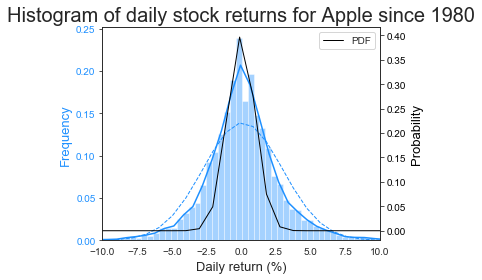

In [26]:
fig, ax1 = plt.subplots()

# Plot the histogram of returns distribution
ax1.set_xlabel("Daily return (%)", size=13)
ax1.set_ylabel("Frequency", size=13, color="dodgerblue")

sns.distplot(AAPL_return_1980, color="dodgerblue", bins=200, label='data distribution')

# Plot normal distribution of the data
xmin, xmax = plt.xlim()  
x = np.linspace(xmin, xmax, 100) 
n = norm.pdf(x, mu, std)
p = norm.pdf(x)
ax1.plot(x, n, "dodgerblue", linewidth=1, ls = 'dashed', label= 'normal distribution')
ax1.tick_params(axis='y', labelcolor="dodgerblue")

# Plot PDF of the data
ax2 = ax1.twinx()
ax2.set_ylabel("Probability", size=13, color="k")  
ax2.plot(x, p, 'k', linewidth=1, label='PDF')
ax2.tick_params(axis='y', labelcolor='k')

plt.title("Histogram of daily stock returns for Apple since 1980", size=20)
plt.xlim([-10, 10])
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Get historical data for a more recent stock: Carvana, CVNA
CVNA_2017 = get_candle_data('CVNA', 'D', 2017, 4, 28, 2020, 8, 23) # Daily data 

ok


In [28]:
# Calculate the returns for this data
CVNA_return_2017 = stock_return(CVNA_2017['c'])

In [29]:
# Mean and standard deviation of the returns
mu, std = norm.fit(CVNA_return_2017)  # Fit normal distribution to data
print("Average historical return: {:.2f} %".format(mu))
print("Historical volatility (1 std): {:.2f} %".format(std))

Average historical return: 0.49 %
Historical volatility (1 std): 5.35 %


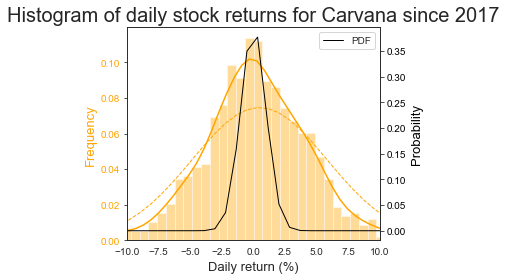

In [30]:
fig, ax1 = plt.subplots()

# Plot the histogram of returns distribution
ax1.set_xlabel("Daily return (%)", size=13)
ax1.set_ylabel("Frequency", size=13, color="orange")

sns.distplot(CVNA_return_2017, color="orange", bins=100, label='data distribution')

# Plot normal distribution of the data
mu, std = norm.fit(CVNA_return_2017)  # Fit normal distribution to data
xmin, xmax = plt.xlim()  
x = np.linspace(xmin, xmax, 100) 
n = norm.pdf(x, mu, std)
p = norm.pdf(x)
ax1.plot(x, n, "orange", linewidth=1, ls = 'dashed', label= 'normal distribution')
ax1.tick_params(axis='y', labelcolor="orange")

# Plot PDF of the data
ax2 = ax1.twinx()
ax2.set_ylabel("Probability", size=13, color="k")  
ax2.plot(x, p, 'k', linewidth=1, label='PDF')
ax2.tick_params(axis='y', labelcolor='k')

plt.title("Histogram of daily stock returns for Carvana since 2017", size=20)
plt.xlim([-10, 10])
plt.legend()
plt.tight_layout()
plt.show()